In [1]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
# import imageio
# import cv2
# import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg


# ML, statistics
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

# Tensorflow
#from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.models import model_from_json, load_model
from tensorflow.python.keras.preprocessing import *
from tensorflow.keras.applications import *
# from tensorflow.keras.initializers import *

from numpy.random import seed

In [2]:
#Asign GPU for train
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

In [ ]:
# df = pd.read_csv("../data/big_sneakers_db_clean.csv")
df = pd.read_csv("../data/sneakers_database_clean.csv")
df.info()

In [ ]:
#view some images of the dataframe
class ImageViewer:
    def plot_images_sample(self,images: np.array,
                           labels: np.array,
                           samples: int,
                           figsize: tuple = (12, 10)):
        """
        samples some images from dataset and
        plot a grid of images with its
        corresponding labels
        """
        #convert pixels


        h = int(np.sqrt(samples))
        w = h

        f, axarr = plt.subplots(h, w, figsize=figsize)

        for i in range(h):
            for j in range(w):
                index = np.random.choice(len(images))
                #convert to pixel before show
                test_image = image.load_img(images[index], target_size=(280,200))
                test_image = image.img_to_array(test_image)
                test_image /= 255.
                axarr[i, j].imshow(test_image)
                axarr[i, j].set_title(f"class-{index}:\n {labels[index]}")
                axarr[i, j].axis('off')
        plt.tight_layout()
        plt.show()



In [ ]:
see_images_df = ImageViewer()
see_images_df.plot_images_sample(df['folder'].to_numpy(),[i for i in df['shoe'].to_numpy()], samples=25)

In [ ]:
class DataPreparation:
    """
    Train/test
    """
    def train_test_split(self, all_df):
        """
        Split dataset into train/validation/test
        """
        # Split to train and test before balancing
        train_df, test_df = train_test_split(all_df, random_state=24)
        # Split train to train and validation datasets
        return train_df, test_df
    
    def plot_balanced(self, train_df, all_df,category):
        """
        Plot samples per category before and after balancing
        """
        
        f, axs = plt.subplots(1,2,figsize=(12,4))
        # train df
        all_df[category].value_counts().plot(kind='bar', ax=axs[0])
        axs[0].set_title('All labels')
        axs[0].set_xlabel('brand')
        axs[0].set_ylabel('Count')
        # After balancing
        train_df[category].value_counts().plot(kind='bar', ax=axs[1])
        axs[1].set_title('Train labels')
        axs[1].set_xlabel('brand')
        axs[1].set_ylabel('Count')
        plt.tight_layout()
        plt.show()



In [ ]:
# Train/test/validation split with balanced labels in train
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(df)

# Plot before delete categories with less than 50 images
data_prep.plot_balanced(train_df, df,"brand")

In [ ]:
n_clases = train_df.groupby("shoe").count().sort_values(by="folder",ascending=False).shape
n_classes = n_clases[0]
print(n_classes)

In [ ]:
data_prep = DataPreparation()
train_df, test_df = data_prep.train_test_split(dfbalanced)

# Plot before delete categories with less than 50 images
data_prep.plot_balanced(train_df, dfbalanced,"brand")

In [3]:
model_name = f"InceptionV3_v11_classweight_504"

In [6]:
class Generators:
    """
    Train, validation and test generators.
    Directory will be none if we have the absolute route on the df. Otherwise, use path to folder.
    """
    def __init__(self, train_df, test_df):
        self.batch_size=50
#         self.batch_size=32
#         self.batch_size=16
        self.img_size=(280,200)
        self.df_y = "shoe"
        self.df_X = "folder"
        
        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.25,
            featurewise_center=False,
            featurewise_std_normalization=False,
#             rotation_range=90,
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest'
            )

        # Train generator
        self.train_generator = _datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col=self.df_X,
            y_col=self.df_y,
            has_ext=False,
#             subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
#         self.val_generator = _datagen.flow_from_dataframe(
#             dataframe=train_df,
#             directory=None,
#             x_col=self.df_X,
#             y_col=self.df_y,
#             has_ext=False,
#             subset="validation",
#             batch_size=self.batch_size,
#             seed=42,
#             shuffle=True,
#             class_mode="categorical",
#             target_size=self.img_size)    
        print('Validation generator created')
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=self.df_X,
            y_col=self.df_y,
            has_ext=False,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')

        
# Create generators        
generators = Generators(train_df, test_df)
print("Generators created")

Found 22563 validated image filenames belonging to 504 classes.
Train generator created
Validation generator created
Found 7521 validated image filenames belonging to 504 classes.
Test generator created
Generators created


/home/migue/miniconda3/envs/ml_rode/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="folder". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/migue/miniconda3/envs/ml_rode/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="folder". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [7]:
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.applications.ResNet152 import preprocess_input, decode_predictions
# from keras.applications.resnet import ResNet50, ResNet152, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions,
from sklearn.utils import class_weight

from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [9]:
class ModelTrainer:
    """
    Create and fit the model. The model will be inizializated from Resnet50
    """

    def __init__(self, generators=None,n_classes=None,model_name=None):
        self.generators = generators
        self.img_width = generators.img_size[0]
        self.img_height = generators.img_size[1]
        self.base_model = InceptionV3(weights='imagenet',include_top=False, input_shape=(self.img_width ,self.img_height ,3))
        self.n_classes = n_classes
        self.model_name = model_name
        for layer in self.base_model.layers:
            layer.trainable = True
    
    def create_model_based_resnet(self):
        """
        Build CNN model using InceptionV3 as base model. 
        """

        X = self.base_model.output
        X = Flatten()(X)

        X = Dense(512, kernel_initializer='he_uniform')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)

        X = Dense(254, kernel_initializer='he_uniform')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Dense(128, kernel_initializer='he_uniform')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Dense(16, kernel_initializer='he_uniform')(X)
        #X = Dropout(0.5)(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)

        output = Dense(self.n_classes, activation='softmax')(X)

        model = Model(inputs=self.base_model.input, outputs=output)
#         optimizer = Adam(lr=0.0001)
        optimizer = SGD(lr=0.01, momentum=0.9)
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer, 
                      metrics=['accuracy'])
        
        
#         def focal_loss(y_true, y_pred):
#             gamma = 2.0
#             alpha = 0.25
#             pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#             pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#             return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

#         # Compile our model
#         adam = Adam(lr=0.0001)
#         model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam) 
        
        
        return model
    
    def train_cnn(self,model):
        print(self.img_width , self.img_height)
        STEP_SIZE_TRAIN=self.generators.train_generator.n//self.generators.train_generator.batch_size
#         STEP_SIZE_VALID=self.generators.val_generator.n//self.generators.val_generator.batch_size
        STEP_SIZE_TEST=self.generators.test_generator.n//self.generators.test_generator.batch_size
        print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_TEST)
        # n_epoch = 100
        n_epoch = 100
        early_stop = EarlyStopping(monitor='val_accuracy', patience=8, verbose=1, mode='auto', restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(f'../models/{self.model_name}.h5',monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True)
        #with weigths 
        counter = Counter(generators.train_generator.classes)                          
        max_val = float(max(counter.values()))       
        class_w = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
        # class_w[131] = 12.11
        # class_w[131] = 12.11
        od = collections.OrderedDict(sorted(class_w.items()))
        class_weights = dict(od)
        len(class_weights)
        class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(generators.train_generator.classes),
                                                         generators.train_generator.classes)
        class_weights = dict(enumerate(class_weights))
        
        #train the model
        training = model.fit_generator(generator=self.generators.train_generator, 
                            steps_per_epoch=STEP_SIZE_TRAIN, 
                            validation_data=self.generators.test_generator, 
                            validation_steps=STEP_SIZE_TEST, 
                            epochs=n_epoch, 
                            shuffle=True, 
                            verbose=1, 
                            class_weight=class_weights,
                            callbacks=[early_stop,reduce_lr,checkpointer])
        return training
    



In [ ]:
# Instance the class
trainer = ModelTrainer(generators,n_classes,model_name)
#Load the model
model = trainer.create_model_based_resnet()
model.summary()
#Train the model
history=trainer.train_cnn(model)
print("Trained")

In [15]:
#save model
model.save(f'../models/complete_model_{model_name}.h5') 

In [18]:
class Evaluation:
    """
    Evaluaion : print report about the performance
    """
#     def __init__(self):
#         self.training = training
#         self.generator = generator
#         # predict the data
#         steps=5
#         self.y_pred_raw = model.predict_generator(self.generator, steps=steps)
#         self.y_pred = np.argmax(self.y_pred_raw, axis=1)
#         self.y_true=y_true[:len(self.y_pred)].map(generators.test_generator.class_indices)        
    

    def plot_training(self, history, metrics: list = ('loss','accuracy'), figsize: tuple = (12, 5)):
        """
        plots training selected metrics for every batch
        """
        epochs = range(1, len(history.history[metrics[0]]) + 1)

        fig, ax_arr = plt.subplots(1, len(metrics), figsize=figsize)

        if not isinstance(ax_arr, np.ndarray):
            ax_arr = np.array(ax_arr).reshape(1, )

        for i, metric in enumerate(metrics):
            ax_arr[i].plot(epochs, history.history[metric], color='k', linestyle='solid', label=metric, linewidth=2)
            ax_arr[i].plot(epochs, history.history[f"val_{metric}"], color='r', linestyle='dotted',
                           label=f'validation {metric}')
            ax_arr[i].set_ylabel(metric)
            ax_arr[i].set_xlabel('epochs')
            ax_arr[i].grid()
            ax_arr[i].legend()
        plt.savefig(f'model_evaluation/vgg19_classweight_504.jpg', dpi=254)
        return plt.show()

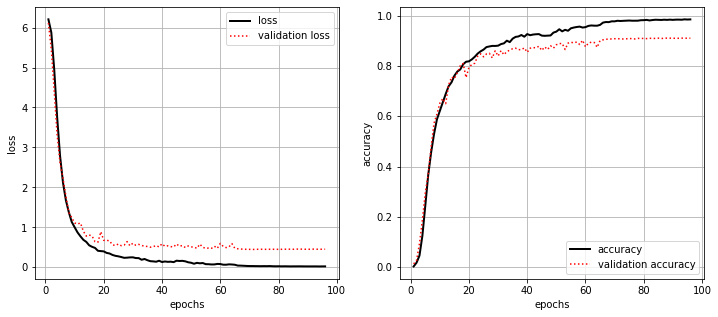

In [19]:
evaluation = Evaluation()
evaluation.plot_training(history, metrics=['loss', 'accuracy'])

In [ ]:
# Create a basic model instance
checkpoint_path = '../models/InceptionV3_v4_307.h5'

# Instanciar the class
model_name = "prediction"

trainer = ModelTrainer(generators,n_classes,model_name)
#Load the model
model = trainer.create_model_based_resnet()

# Evaluate the model
# loss, acc = model.evaluate(generators.test_generator, verbose=1)
# print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

#load model weight
model.load_weights(checkpoint_path)


In [ ]:
#Load from complete folder
model = tf.keras.models.load_model('../models/complete_model_InceptionV3_v11_noweight_504.h5')

In [ ]:
#evaluate model
STEP_SIZE_TEST=generators.test_generator.n//generators.test_generator.batch_size
loss, acc = model.evaluate(generators.test_generator, verbose=1,steps=STEP_SIZE_TEST)
print('Restored model, accuracy: {:5.2f}%, loss:{:5.2f}%'.format(100*acc,100*loss))

In [ ]:
weights = model.get_weights() 
len()

In [ ]:
from PIL import Image
import heapq
import operator
import cv2  
# import os.path
# from object_detection.utils import label_map_util
# from object_detection.utils import visualization_utils as vis_util

class Prediction:
    """
    Create a plot with the different prediction options
    """
    def __init__(self):
        self.label_encoded = generators.train_generator.class_indices
   
    def img_operations(self,img_url):
        image = Image.open(img_url).convert('RGB') 
        width, height = Image.open(img_url).size
        
        new_image = image.resize((200, 280))
        new_image.save('temp/test.jpg')
        
#         immm = Image.open('temp/test.jpg') 
#         # Setting the points for cropped image 
#         left = 10
#         top = 50
#         right = 290
#         bottom = 250

#         # Cropped image of above dimension 
#         # (It will not change orginal image) 
#         imm1 = immm.crop((left, top, right, bottom)) 

#         # Shows the image in image viewer 
#         # imm1.show() 
#         imm1.save('temp/test.jpg', optimize=True)
        img_saved = 'temp/test.jpg'
        return img_saved
    
    def from_url(self,img_url,brand=None):

        if img_url:
            url_test = img_url
        else:
            url_test = 'temp/test.jpg'
        
        # Original image
        image = Image.open(url_test).convert('RGB') 
        
        # Original image
        test_image = Image.open(url_test).convert('RGB') 

        # Predict shoe model
        #adjust img to the model size
        test_image = img_to_array(test_image)
        test_image /= 255.
        test_image = np.expand_dims(test_image, axis=0)

        #prediction
        prediction = model.predict(test_image)
        prediction_probability = np.amax(prediction)
#             print(prediction_probability)
        a = prediction.flatten()
        indexed = list(enumerate(a))
        top_3 = sorted(indexed, key=operator.itemgetter(1))[-5:]

        percentages = reversed([v for i, v in top_3])
        index = reversed([i for i, v in top_3])



        prediction_idx = np.argmax(prediction)
        #labels
        labels = self.label_encoded
        labels = dict((v,k) for k,v in labels.items())

        class_names = [labels[x] for x in index]
        per = [y for y in percentages]

        graphic_index_pred = [p if a==labels[prediction_idx].replace('_', ' ') else 1 for p,a in enumerate(class_names) ]
        graphic_index_true = [p if a==brand.replace('_', ' ') else 1 for  p,a in enumerate(class_names) ]
        title = "Real Brand = {}\nPredicted Brand = {}\nPrediction probability = {:.2f} %".format(brand.replace('_', ' '), 
                                                                                        labels[prediction_idx].replace('_', ' '),
                                                                                        prediction_probability*100)

        true_class = brand.replace('_', ' ')
        predicted_class = labels[prediction_idx].replace('_', ' ')

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,2))

        axes[0].imshow(plt.imread(url_test))
        axes[0].axis('off')
        axes[0].set_title(f"{title}", color='blue' if brand.replace('_', ' ') == labels[prediction_idx].replace('_', ' ') else 'red')

        axes[1].barh(class_names,
                     per, 
                     color='black')
        axes[1].get_children()[graphic_index_pred[0]].set_color('red')
        axes[1].get_children()[graphic_index_true[0]].set_color('blue')
#         axes[1].set_xlim(0, 1)
        axes[1].set_title("class probabilities")
        axes[1].set_xlabel("probability")
        axes[1].set_ylabel("class name")
        plt.show()

    
    
    def index_prediction(self,brand,img_dir,indexes:list):
        for index in indexes:

            #find column index
            nbrand = test_df.columns.get_loc("shoe")
            #find brand for index
            real_brand = test_df.iloc[index,nbrand]
            #find column index
            nfold = test_df.columns.get_loc("folder")
            #find url file for index
            image_file = test_df.iloc[index,nfold]

            # Original image
            test_image = load_img(image_file, target_size=(280,200))

            # Predict shoe model
            #adjust img to the model size
            test_image = img_to_array(test_image)
            test_image /= 255.
            test_image = np.expand_dims(test_image, axis=0)
            
            #prediction
            prediction = model.predict(test_image)
            prediction_probability = np.amax(prediction)
#             print(prediction_probability)
            a = prediction.flatten()
            indexed = list(enumerate(a))
            top_3 = sorted(indexed, key=operator.itemgetter(1))[-5:]
            
            percentages = reversed([v for i, v in top_3])
            index = reversed([i for i, v in top_3])
            
            
            
            prediction_idx = np.argmax(prediction)
            #labels
            labels = self.label_encoded
            labels = dict((v,k) for k,v in labels.items())
            
            class_names = [labels[x] for x in index]
            per = [y for y in percentages]
            
            graphic_index_pred = [p for p,a in enumerate(class_names) if a==labels[prediction_idx]]
            graphic_index_true = [p for p,a in enumerate(class_names) if a==real_brand.replace('_', ' ')]

                             
            title = "Real Brand = {}\nPredicted Brand = {}\nPrediction probability = {:.2f} %".format(real_brand.replace('_', ' '), 
                                                                                            labels[prediction_idx].replace('_', ' '),
                                                                                            prediction_probability*100)

            true_class = real_brand.replace('_', ' ')
            predicted_class = labels[prediction_idx].replace('_', ' ')

            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,2))

            axes[0].imshow(plt.imread(image_file))
            axes[0].axis('off')
            axes[0].set_title(f"{title}", color='blue' if real_brand.replace('_', ' ') == labels[prediction_idx].replace('_', ' ') else 'red')

            axes[1].barh(class_names,
                         per, 
                         color='black')
            axes[1].get_children()[graphic_index_pred[0]].set_color('red')
            axes[1].get_children()[graphic_index_true[0]].set_color('blue')
            axes[1].set_xlim(0, 1)
            axes[1].set_title("class probabilities")
            axes[1].set_xlabel("probability")
            axes[1].set_ylabel("class name")
            
            
    def random_prediction(self,brand,img_dir,n):
        long = test_df.shape[0]
        for index in range(n):
            randd = random.randint(0, long+1)

            #find column index
            nbrand = test_df.columns.get_loc("shoe")
            #find brand for index
            real_brand = test_df.iloc[randd,nbrand]
            #find column index
            nfold = test_df.columns.get_loc("folder")
            #find url file for index
            image_file = test_df.iloc[randd,nfold]

            # Original image
            test_image = load_img(image_file, target_size=(280,200))

            # Predict shoe model
            #adjust img to the model size
            test_image = img_to_array(test_image)
            test_image /= 255.
            test_image = np.expand_dims(test_image, axis=0)

            #prediction
            prediction = model.predict(test_image)
            prediction_probability = np.amax(prediction)
#             print(prediction_probability)
            a = prediction.flatten()
            indexed = list(enumerate(a))
            top_3 = sorted(indexed, key=operator.itemgetter(1))[-5:]

            percentages = reversed([v for i, v in top_3])
            index = reversed([i for i, v in top_3])
            prediction_idx = np.argmax(prediction)
            
            #labels
            labels = self.label_encoded
            labels = dict((v,k) for k,v in labels.items())
            class_names = [labels[x] for x in index]
            per = [y for y in percentages]

            graphic_index_pred = [a if a==labels[prediction_idx].replace('_', ' ') else 1 for p,a in enumerate(class_names) ]
            graphic_index_true = [a if a==real_brand.replace('_', ' ') else 1 for  p,a in enumerate(class_names) ]
            title = "index{}\nReal Brand = {}\nPredicted Brand = {}\nPrediction probability = {:.2f} %".format(randd,
                                                                                            real_brand.replace('_', ' '), 
                                                                                            labels[prediction_idx].replace('_', ' '),
                                                                                            prediction_probability*100)
#             print(randd)
            position_pred = [b for b,a in enumerate(graphic_index_pred) if  isinstance(a, str) ]
            position_true = [b for b,a in enumerate(graphic_index_true) if  isinstance(a, str) ]
            
#             print(randd,position_true[0])

            true_class = real_brand.replace('_', ' ')
            predicted_class = labels[prediction_idx].replace('_', ' ')

            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,2))

            axes[0].imshow(plt.imread(image_file))
            axes[0].axis('off')
            axes[0].set_title(f"{title}", color='blue' if real_brand.replace('_', ' ') == labels[prediction_idx].replace('_', ' ') else 'red')

            axes[1].barh(class_names,
                         per, 
                         color='black')
            if position_pred[0]<5:
                axes[1].get_children()[position_pred[0]].set_color('red')
            if (len(position_true)>0) and (position_true[0]<5):
                axes[1].get_children()[position_true[0]].set_color('blue')
            axes[1].set_xlim(0, 1)
            axes[1].set_title("class probabilities")
            axes[1].set_xlabel("probability")
            axes[1].set_ylabel("class name")
    
    def shoe_detection(self,img_url):
        from object_detection.utils import ops as utils_ops
        from object_detection.utils import label_map_util
        from object_detection.utils import visualization_utils as vis_util
        # Import utilites
#         import tensorflow.compat.v1 as tff
#         tff.disable_v2_behavior()


        # patch tf1 into `utils.ops`
        utils_ops.tf = tf.compat.v1

        # Patch the location of gfile
        tf.gfile = tf.io.gfile


        
        #Path to load model weights
        PATH_TO_CKPT = '../models/shoe_detection/frozen_inference_graph.pb'
        # Path to label map file
        PATH_TO_LABELS = '../models/shoe_detection/label_map.pbtxt'
#         category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
        
        category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)
        
        # Load the Tensorflow model into memory.
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.compat.v1.GraphDef() 
            with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

            sess = tf.compat.v1.Session(graph=detection_graph)

        # Define input and output tensors (i.e. data) for the object detection classifier

        # Input tensor is the image
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

        # Output tensors are the detection boxes, scores, and classes
        # Each box represents a part of the image where a particular object was detected
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

        # Each score represents level of confidence for each of the objects.
        # The score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

        # Number of objects detected
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        # Load image using OpenCV and
        # expand image dimensions to have shape: [1, None, None, 3]
        # i.e. a single-column array, where each item in the column has the pixel RGB value

        filename = img_url
        # image = cv2.imread(os.path.join(PATH_TO_IMAGE_FOLDER, filename))
        image = cv2.imread(filename)
        image_expanded = np.expand_dims(image, axis=0)

        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_expanded})
        # output_dict = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],feed_dict={image_tensor: image_expanded})
        # Draw the results of the detection (aka 'visulaize the results')


        vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=5,
            min_score_thresh=0.70)

#         plt.show()
        #crop the detected image
        img_height, img_width, img_channel = image.shape
        absolute_coord = []
        THRESHOLD = 0.7 # adjust your threshold here
        N = len(boxes)
        for i in range(N):
            if scores[i][0] < THRESHOLD:
                continue
            box = boxes[0][0]
            ymin, xmin, ymax, xmax = box
            x_up = int(xmin*img_width)
            y_up = int(ymin*img_height)
            x_down = int(xmax*img_width)
            y_down = int(ymax*img_height)
            absolute_coord.append((x_up,y_up,x_down,y_down))
        bounding_box_img = []
        for c in absolute_coord:
            bounding_box_img.append(image[c[1]:c[3], c[0]:c[2],:])
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,8))   
        axes[0].axis('off')
        axes[0].imshow(image)
#         axes[0].savefig(f'{filename}-detected.jpg', dpi=254)    
            
        axes[1].axis('off')
        axes[1].imshow(bounding_box_img[0])
        figure, ax = plt.subplots()
        plt.imshow(bounding_box_img[0])
        plt.axis('off')
        plt.savefig(f'{filename}-cropdetected.jpg', dpi=254)
#         plt.show()
        im = Image.fromarray(bounding_box_img[0])
        im.save('test2.jpg')
    
        image_final_url = f'{filename}-cropdetected.jpg'
        return image_final_url
    
    def shoe_detection_px (self,brand,img_dir,n):
        import plotly.express as px
        long = test_df.shape[0]
        for index in range(n):
            randd = random.randint(0, long+1)
#             randd = 1003
            #find column index
            nbrand = test_df.columns.get_loc("shoe")
            #find brand for index
            real_brand = test_df.iloc[randd,nbrand]
            #find column index
            nfold = test_df.columns.get_loc("folder")
            #find url file for index
            image_file = test_df.iloc[randd,nfold]

            # Original image
            test_image = load_img(image_file, target_size=(280,200))

            # Predict shoe model
            #adjust img to the model size
            test_image = img_to_array(test_image)
            test_image /= 255.
            test_image = np.expand_dims(test_image, axis=0)

            #prediction
            prediction = model.predict(test_image)
            prediction_probability = np.amax(prediction)
#             print(prediction_probability)
            a = prediction.flatten()
            indexed = list(enumerate(a))
            top_3 = sorted(indexed, key=operator.itemgetter(1))[-5:]

            percentages = reversed([v for i, v in top_3])
            index = reversed([i for i, v in top_3])
            prediction_idx = np.argmax(prediction)
            
            #labels
            labels = self.label_encoded
            labels = dict((v,k) for k,v in labels.items())
            class_names = [labels[x] for x in index]
            per = [y for y in percentages]

            graphic_index_pred = [a if a==labels[prediction_idx].replace('_', ' ') else 1 for p,a in enumerate(class_names) ]
            graphic_index_true = [a if a==real_brand.replace('_', ' ') else 1 for  p,a in enumerate(class_names) ]
            title = "index{}\nReal Brand = {}\nPredicted Brand = {}\nPrediction probability = {:.2f} %".format(randd,
                                                                                            real_brand.replace('_', ' '), 
                                                                                            labels[prediction_idx].replace('_', ' '),
                                                                                            prediction_probability*100)
#             print(randd)
            position_pred = [b for b,a in enumerate(graphic_index_pred) if  isinstance(a, str) ]
            position_true = [b for b,a in enumerate(graphic_index_true) if  isinstance(a, str) ]
            
#             print(randd,position_true[0])

            true_class = real_brand.replace('_', ' ')
            predicted_class = labels[prediction_idx].replace('_', ' ')

        
            if position_pred == position_true:
                colorbh = ["True Prediction" if  isinstance(a, str) else "other predictions" for a in graphic_index_true] 
            else:
                colorbh = ["other predictions" for i in range(0,5)]
                colorbh[position_pred[0]] = "Predicted Brand"
                colorbh[position_true[0]] = "Real Brand"
            
            fig =px.bar( x=per, y=class_names ,orientation='h',title=title,color=colorbh)
            fig.update_layout(
                title_font_color='blue' if real_brand.replace('_', ' ') == labels[prediction_idx].replace('_', ' ') else 'red'
            )
            
            fig.show()
        
        
#             fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,2))

#             axes[0].imshow(plt.imread(image_file))
#             axes[0].axis('off')
#             axes[0].set_title(f"{title}", color='blue' if real_brand.replace('_', ' ') == labels[prediction_idx].replace('_', ' ') else 'red')

#             axes[1].barh(class_names,
#                          per, 
#                          color='black')
#             if position_pred[0]<5:
#                 axes[1].get_children()[position_pred[0]].set_color('red')
#             if (len(position_true)>0) and (position_true[0]<5):
#                 axes[1].get_children()[position_true[0]].set_color('blue')
#             axes[1].set_xlim(0, 1)
#             axes[1].set_title("class probabilities")
#             axes[1].set_xlabel("probability")
#             axes[1].set_ylabel("class name")

In [ ]:
prediction = Prediction()


In [ ]:
prediction.shoe_detection_px(test_df['shoe'].values,test_df['folder'].values,3) 

In [ ]:
prediction.random_prediction(test_df['shoe'].values,test_df['folder'].values,5) 

In [ ]:
url_test = "../imgs/adidas-iniki-runner-70s-pride-1.jpg"

In [ ]:
to_test = prediction.shoe_detection(url_test)

In [ ]:
img_path = prediction.img_operations(url_test)
prediction.from_url(img_path,"adidas iniki runner")

In [ ]:
img_path = prediction.img_operations(to_test)
prediction.from_url(img_path,"adidas iniki runner")

In [ ]:
img_path = prediction.img_operations(url_test)
image = Image.open(img_path).convert('RGB') 
new_image = image.resize((224,224 ))
new_image.save('temp/test_computer_vistion.jpg')